# Lab 8: Computer Vision (Image Segmentation)
COSC 410: Applied Machine Learning\
Colgate University\
*Prof. Apthorpe*

This lab is due to Gradescope by the beginning of lab next week (2:45p on 3/31). You may work with a partner on this lab – if you do, submit only one solution as a “group” on Gradescope.
## Introduction

The purpose of this lab is for you to practice implementing convolutional neural networks to perform image segmentation, a crucial task for computer vision applications. Upon completing this lab, you should be comfortable creating CNNs with convolutional, deconvolutional, and pooling layers, as well as residual (skip) connections. You will also gain experience with Keras's `ImageDataGenerator` class for image augmentation. 

We will be using a new dataset, the **MIT Scene Parsing Benchmark**. This dataset contains a a collection of 256x256 pixel RGB images various real-world scenes. Every images has label for *each pixel* indicating to which of 150 object categories the pixel belongs. **You should start this lab by visiting http://sceneparsing.csail.mit.edu/, reading the overview, and browsing the validation set** to familiarize yourself with the data format. 

## Provided Files
 * `Lab8.ipynb`: This file
 
## Part 1: Data Import and Exploration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as ks
np.random.seed(0)
tf.random.set_seed(1)

For the sake of download speed, we will be using the MIT Scene Parsing Benchmark validation set (which contains 2000 images) rather than then full training set (which contains 20210 images).

The following cell defines a function that creates `ImageDataGenerator` objects for the images and corresponding labels. When dealing with large image datasets, it is impractical to keep all of the images in memory. Instead, we create *generators* that will load, preprocess, and provide each *batch* of images and labels as needed during training. 

In [3]:
def prepare_data(seed=1):
    image_gen = ks.preprocessing.image.ImageDataGenerator(rescale = 1/255, horizontal_flip=True, vertical_flip=True, rotation_range=180, zoom_range=1.0, shear_range=180)
    labels_gen = ks.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=180, width_shift_range=1.0, height_shift_range=1.0, zoom_range=1.0, shear_range=180)
    
    images = image_gen.flow_from_directory("ADEChallengeData2016/validation", class_mode=None, seed=seed)
    labels = labels_gen.flow_from_directory("ADEChallengeData2016/validation_labels", class_mode=None, seed=seed)
    data = zip(images, (x[:,:,:,0] for x in labels))
    
    return data

Let's see how this generator works. The `examine_data()` function prints the shapes of the first batch of images and labels then displays the first 10 images and labels.

Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Shape of training image batch 0: (32, 256, 256, 3)
Shape of training label batch 0: (32, 256, 256)


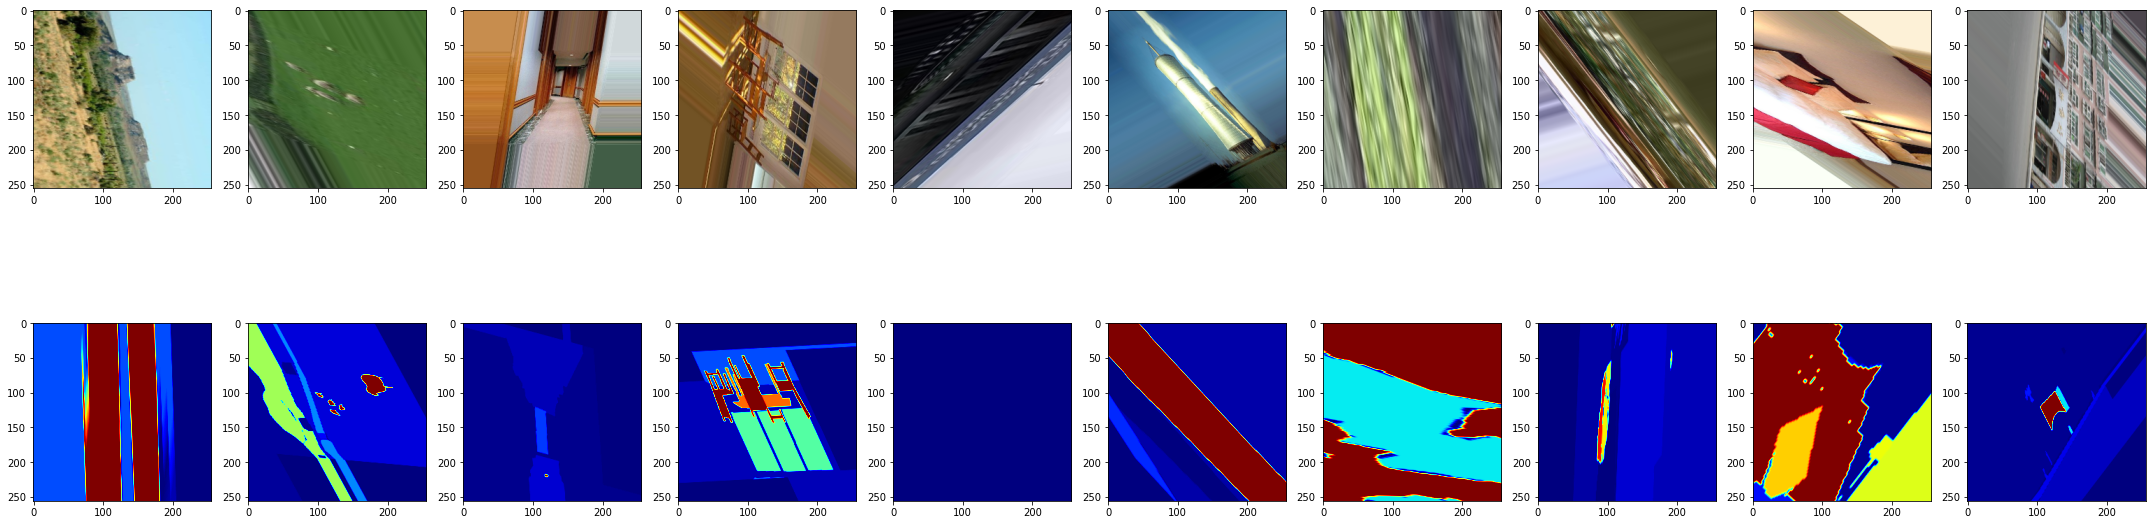

In [4]:
def examine_data():
    data = prepare_data()
    
    image_batch0, label_batch0 = next(data)
    print(f"Shape of training image batch 0: {image_batch0.shape}")
    print(f"Shape of training label batch 0: {label_batch0.shape}")
    
    fig = plt.figure(tight_layout='auto', figsize=(30, 10))
    for i in range(10):
        fig.add_subplot(2, 10, i+1)
        plt.imshow(image_batch0[i])
        fig.add_subplot(2, 10, i+11)
        plt.imshow(label_batch0[i], cmap="jet")

examine_data()

**Question 1:** The first batch of **images** has shape `(32, 256, 256, 3)`. In the following text cell, explain why each of these numbers are what they are.

The first batch has 32 images in it, hence 3. Each image is of size 256 x 256, hence the two 256 numbers. Since the images are colored, they need a third dimension with a value of 3 to represent the three RGB color channels, hence 3.

**Question 2:** The first batch of **labels** has shape `(32, 256, 256)`. In the following text cell, explain why the labels do not have a color channels dimension and what the values of the labels represent.

The labels do not have a color channel because each label is the original image after undergoing image segmentation, which turns the original image into grayscale, and so there is no color channel. (32, 256, 256) denotes that there are 32 images in the batch, each of size 256 x 256.

## Part 2: Creating a U-Net

Your task is to create a model with the below U-NET architecture. In the following cell, create (but do not compile or train) a Keras model object defining the following network architecture. You will need to use the functional API in order to configure the residual connections. Here are some tips:
  * Use `Conv2D` layers for the Conv operations
  * Use `MaxPooling2D` layers for the MaxPool operations
  * Use `Conv2DTranspose` layers for the Deconv operations
  * Use `Concatenate` layers for the Concatenate operations
  * Use `Dropout` layers for the Dropout operations
  
Look up these layers and the associated keyword arguments in the Keras documentation as needed

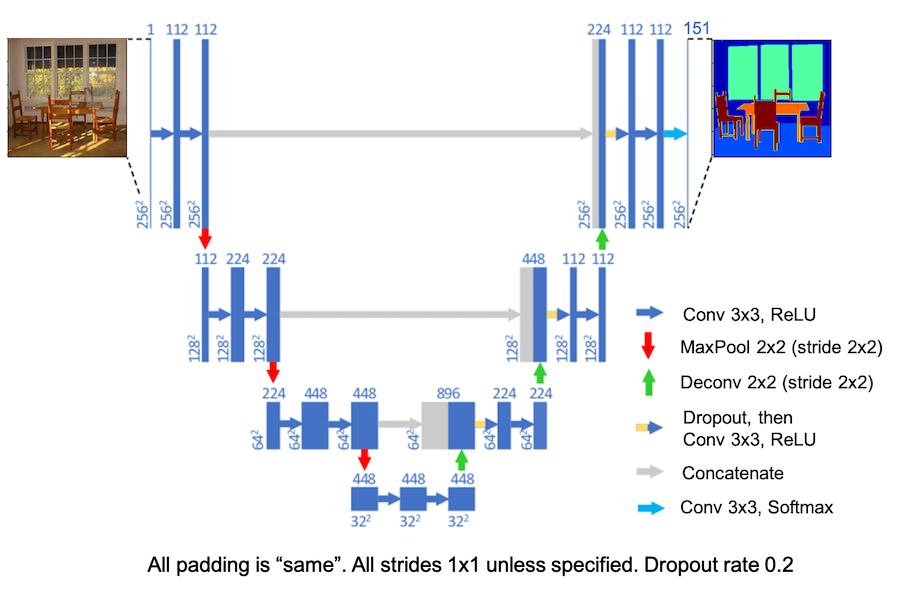

In [5]:


input = ks.layers.Input(shape=(256, 256, 3), batch_size=32) 

convLayer1 = ks.layers.Conv2D(filters=3, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (input) 
convLayer1 = ks.layers.Conv2D(filters=112, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (convLayer1)
maxPool1 = ks.layers.MaxPooling2D(pool_size=(2,2)) (convLayer1)

convLayer2 = ks.layers.Conv2D(filters=112, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (maxPool1) 
convLayer2 = ks.layers.Conv2D(filters=224, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (convLayer2)
maxPool2 = ks.layers.MaxPooling2D(pool_size=(2,2)) (convLayer2)

convLayer3 = ks.layers.Conv2D(filters=224, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (maxPool2) 
convLayer3 = ks.layers.Conv2D(filters=448, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (convLayer3)
maxPool3 = ks.layers.MaxPooling2D(pool_size=(2,2)) (convLayer3)

centerLayer = ks.layers.Conv2D(filters=448, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (maxPool3)
centerLayer = ks.layers.Conv2D(filters=448, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (centerLayer)
unpool1 = ks.layers.Conv2DTranspose(filters=448, kernel_size=(2,2), strides=(2,2))(centerLayer)

concatLayer3 = ks.layers.Concatenate(axis=3)([convLayer3, unpool1])
dconLayer1 = ks.layers.Dropout(0.2) (concatLayer3)
dconLayer1 = ks.layers.Conv2D(filters=224, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (dconLayer1)
dconLayer1 = ks.layers.Conv2D(filters=224, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (dconLayer1)
unpool2 = ks.layers.Conv2DTranspose(filters=224, kernel_size=(2,2), strides=(2,2))(dconLayer1)

concatLayer2 = ks.layers.Concatenate(axis=3)([convLayer2, unpool2])
dconLayer2 = ks.layers.Dropout(0.2) (concatLayer2)
dconLayer2 = ks.layers.Conv2D(filters=112, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (dconLayer2)
dconLayer2 = ks.layers.Conv2D(filters=112, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (dconLayer2)
unpool3 = ks.layers.Conv2DTranspose(filters=112, kernel_size=(2,2), strides=(2,2))(dconLayer2)

concatLayer1 = ks.layers.Concatenate(axis=3)([convLayer1, unpool3])
dconLayer3 = ks.layers.Dropout(0.2) (concatLayer1)
dconLayer3 = ks.layers.Conv2D(filters=112, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (dconLayer3)
dconLayer3 = ks.layers.Conv2D(filters=112, kernel_size=(3,3), padding="same", strides=(1,1), activation="relu") (dconLayer3)
output = ks.layers.Conv2D(filters=3, kernel_size=(3,3), padding="same", strides=(1,1), activation="softmax") (dconLayer3)

model = ks.Model(inputs=input, outputs=output)


In the following cell, print either a summary or an arrow diagram of your model and inspect it to make sure it matches the architecture diagram above.

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(32, 256, 256, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (32, 256, 256, 3)    84          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (32, 256, 256, 112)  3136        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (32, 128, 128, 112)  0           ['conv2d_1[0][0]']               
                                                                                              

Next, compile your model your choice of loss function, your choice of optimizer, and the `"accuracy"` metric.

In [7]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

**Question 3:** Why did you choose this loss function? (*Hint:* What is the format of the labels?)

The labels are image-segmented grayscale versions of the original images, which each pixel's color (RGB value) denoting the class to which it belongs. Thus, we would need to use some form of categorical cross-entropy loss function. Since the labels are not encoded in one-hot, we use sparse_categorical_crossentropy.

Next, use the following cell to train your model. Note that the `.fit()` automatically knows that the data generator returned by `prepare_data()` produces batches of examples and labels. 

**Important Note:** Training deep CNNs for image segmentation is one of the most computationally expensive tasks in ML. Since you are running this notebook on your personal computer and not on a cloud server with many GPUs or a distributed datacenter, you are not expected to fully train this network for the lab. Instead, you should use the first epoch of training for debugging to make sure there are no runtime errors in your architecture creation or model compilation. If the first few **batches** of training complete successfully, you can be assured that running many epochs to improve model performance would also be successful. You can then interrupt the kernel and continue with the lab.

In [8]:
model.fit(prepare_data(), steps_per_epoch=62, epochs=1)

Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
 1/62 [..............................] - ETA: 59:19 - loss: 5.0167 - accuracy: 0.0021

**Question 4:** Why is the number of steps (batches) per epoch set to 62? (*Hint:* Consider the size of the dataset, the batch size, and the validation split)

The dataset has 2000 images, and the batch size is 32; thus, the number of batches/steps per epoch is 2000/32 = 62.5.

**Question 5:** Given Keras's estimate of the time it would take to complete the first epoch, how long would it take to train the network for 50 epochs?

Kera's estimate of the time to complete the first epoch is approximately 1 hour; thus, to train the network for 50 epochs would take approximately 50 hours.

## Part 3: Training Set Augmentation

CNN models for image segmentation often perform substantially better when the training set is *augmented* to include modifications of the original images. This teaches the network that minor changes to the image should not affect the pixel classifications. 

For this part of the lab, return to the code in Part 1 and modify the following lines to implement training set augmentation using the Keras `ImageDataGenerator` class

```
image_gen = ks.preprocessing.image.ImageDataGenerator(rescale = 1/255)
labels_gen = ks.preprocessing.image.ImageDataGenerator()
```

The documentation for this class is here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator.

Add keyword arguments such that random rotations, shears, zooms, and flips are applied to **both** the training images and the training labels. 

Finally, re-run your code through Part 2 to make sure that the first epoch of training still works and that you haven't introduced any new bugs into the code. 

# Submission Instructions
Submit your completed  `Lab8.ipynb` to Gradescope. Be sure to list all of your group members in the submission!